/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 48s 206ms/step - accuracy: 0.7747 - loss: 4.6252 - val_accuracy: 0.5017 - val_loss: 11.3672
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8389 - loss: 0.5086 - val_accuracy: 0.8240 - val_loss: 0.4966
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8775 - loss: 0.3449 - val_accuracy: 0.8504 - val_loss: 0.5447
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.8674 - loss: 0.3815 - val_accuracy: 0.8491 - val_loss: 0.3328
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8910 - loss: 0.2805 - val_accuracy: 0.9186 - val_loss: 0.2020
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8813 - loss: 0.2807 - val_accuracy: 0.8802 - val_loss: 0.4268
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8936 - loss: 0.2528 - val_accuracy: 0.9365 - val_loss: 0.1581
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.9123 - loss: 

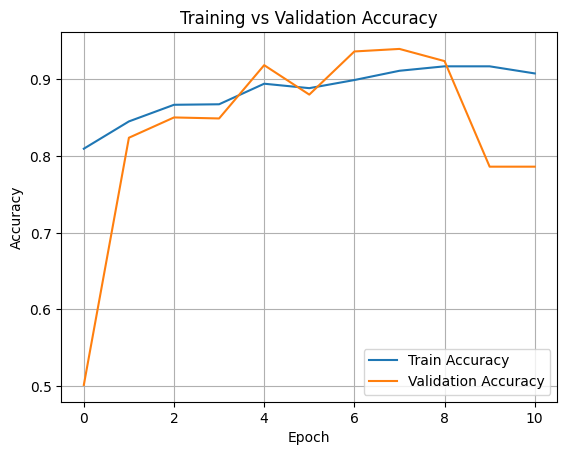

In [1]:
!mkdir -p /content/face_mask_dataset
!unzip -o -q /content/face_mask_dataset.zip -d /content/

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
data_path = "/content/face_mask_dataset"
categories = ["with_mask", "without_mask"]
data = []
labels = []
IMG_SIZE = 128  # Boosted resolution for better results

for category in categories:
    folder_path = os.path.join(data_path, category)
    label = category

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            data.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Normalize and convert to NumPy
data = np.array(data) / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=20,
                    callbacks=[early_stop])
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
model.save("high_accuracy_mask_detector.h5")
